In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge, LassoCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import xgboost as xgb
import lightgbm as lgb

from src.sanity import *

from src.load_datasets import (
    load_air_polution_data,
    load_air_quality_data,
    load_climate_change_data,
)

from src.utils import show_dataset, show_series, plot_metrics
from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
)

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")

In [3]:
dataframe = load_air_polution_data()
print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

dataframe shape (43800, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  41757 non-null  float64
 2   dewp       43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB
None


,date,pollution,dewp,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [4]:
dataframe["date"] = pd.to_datetime(dataframe["date"])

dataframe.set_index(keys="date", inplace=True)

# dataframe.sort_values(by='date',inplace=True)
dataframe.sort_index(ascending=True)

dataframe["pollution"] = dataframe["pollution"].interpolate()

print(f"dataframe shape {dataframe.shape}")

dataframe = dataframe.resample("D").mean(numeric_only=True)

print(f"dataframe shape {dataframe.shape}")

dataframe shape (43800, 8)
dataframe shape (1825, 7)


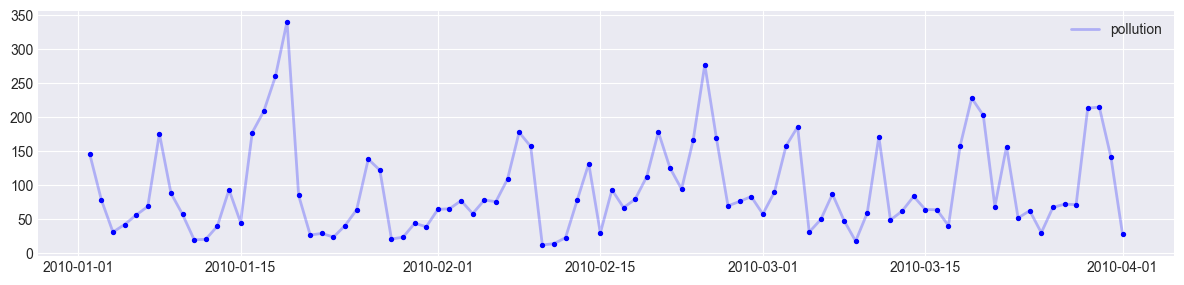

In [5]:
show_dataset(dataframe[:90], columns=["pollution"])

In [6]:
def test_train_split(dataframe: pd.DataFrame, test_size: int):
    dataframe_ = dataframe.copy(deep=True)
    if isinstance(dataframe_.index, pd.DatetimeIndex) is False:
        return
    dataframe_.sort_index(ascending=True)

    train_df = dataframe_[:-test_size].copy(deep=True)
    test_df = dataframe_[-test_size:].copy(deep=True)

    return train_df, test_df


train_data, test_data = test_train_split(dataframe, test_size=30)

print(f"Train Size : {train_data.shape}")
print(f"Test  Size : {test_data.shape} ")

Train Size : (1795, 7)
Test  Size : (30, 7) 


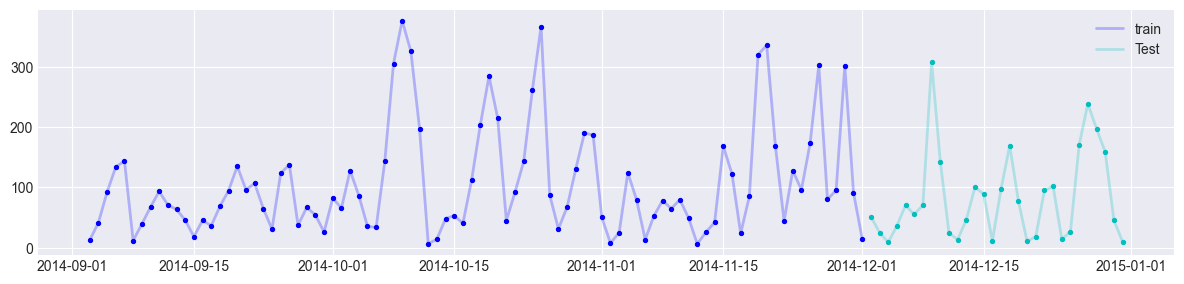

In [7]:
show_series(
    [train_data["pollution"][-90:], test_data["pollution"]], labels=["train", "Test"]
)

In [8]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "pollution"


def change_to_float(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe_ = dataframe.copy(deep=True)
    return dataframe_.astype(float)


train_data_feat = (
    train_data.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(change_to_float)
)

test_data_feat = (
    test_data.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(change_to_float)
)

print(f"train_data_feat shape {train_data_feat.shape}")
print(f"test_data_feat shape {test_data_feat.shape}")

test_data_feat.head()

train_data_feat shape (1795, 26)
test_data_feat shape (30, 26)


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2014-12-02,51.791667,-19.500000,-5.000000,1027.833333,38.071250,0.0,0.0,NaN,NaN,28.791667,...,2.0,49.0,0.0,1.0,0.909297,-0.416147,-0.536573,0.843854,0.149847,-0.988709
2014-12-03,25.375000,-22.250000,-2.791667,1026.625000,53.080417,0.0,0.0,51.791667,NaN,28.791667,...,3.0,49.0,0.0,1.0,0.141120,-0.989992,-0.536573,0.843854,-0.751007,-0.660294
2014-12-04,9.208333,-22.416667,-2.000000,1027.375000,60.924583,0.0,0.0,25.375000,51.791667,28.791667,...,4.0,49.0,0.0,1.0,-0.756802,-0.653644,-0.536573,0.843854,-0.961389,0.275192
2014-12-05,36.375000,-20.250000,-2.750000,1027.208333,14.563333,0.0,0.0,9.208333,25.375000,23.652778,...,5.0,49.0,0.0,0.0,-0.958924,0.283662,-0.536573,0.843854,-0.287874,0.957668
2014-12-06,70.541667,-16.541667,-1.958333,1026.291667,4.210833,0.0,0.0,36.375000,9.208333,38.708333,...,6.0,49.0,1.0,0.0,-0.279415,0.960170,-0.536573,0.843854,0.650311,0.759668


In [9]:
train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data_feat shape {train_data_feat.shape}")
print(f"test_data_feat shape {test_data_feat.shape}")
print(train_data_feat.isna().sum().sum())
train_data_feat.head()

train_data_feat shape (1793, 26)
test_data_feat shape (30, 26)
0


,pollution,dewp,temp,press,wnd_spd,snow,rain,pollution_lag_1,pollution_lag_2,pollution_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,78.833333,145.958333,85.375000,...,4.0,1.0,0.0,1.0,-0.756802,-0.653644,0.841471,0.540302,-0.756802,-0.653644
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.0,0.0,31.333333,78.833333,50.875000,...,5.0,1.0,0.0,1.0,-0.958924,0.283662,0.841471,0.540302,-0.958924,0.283662
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.0,0.0,42.458333,31.333333,43.402778,...,6.0,1.0,0.0,1.0,-0.279415,0.960170,0.841471,0.540302,-0.279415,0.960170
2010-01-07,69.000000,-21.250000,-12.500000,1034.083333,10.170000,0.0,0.0,56.416667,42.458333,55.958333,...,7.0,1.0,0.0,1.0,0.656987,0.753902,0.841471,0.540302,0.656987,0.753902
2010-01-08,176.208333,-17.125000,-11.708333,1028.000000,1.972917,0.0,0.0,69.000000,56.416667,100.541667,...,8.0,1.0,0.0,0.0,0.989358,-0.145500,0.841471,0.540302,0.989358,-0.145500


In [10]:
def seperate_target(dataframe: pd.DataFrame, target_columns: str):
    dataframe_ = dataframe.copy(deep=True)
    target_columns = (
        target_column if isinstance(target_columns, list) else [target_columns]
    )
    target = dataframe_[target_columns].copy(deep=True)

    for col in target_columns:
        dataframe_.pop(col)

    return dataframe_, target


train_x, train_y = seperate_target(train_data_feat, "pollution")
test_x, test_y = seperate_target(test_data_feat, "pollution")

print(train_x.isna().sum().sum())
print(f"Train Size {train_x.shape} {train_y.shape}")
print(f"Test Size {test_x.shape} {test_y.shape}")

0
Train Size (1793, 25) (1793, 1)
Test Size (30, 25) (30, 1)


In [11]:
# train_y.head()
# train_y.pollution.to_numpy()

In [12]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    return actual - predicted


def mae(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_error(actual, predicted)))


def mse(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mse(actual, predicted))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    return _error(actual, predicted) / (actual + EPSILON)


def mape(actual: np.ndarray, predicted: np.ndarray):
    return np.mean(np.abs(_percentage_error(actual, predicted)))


METRICS = {"mae": mae, "rmse": rmse, "mape": mape, "r2": r2_score}


def evaluate(actual: np.ndarray, predicted: np.ndarray):
    results = {}
    metrics = ("mae", "rmse", "mape", "r2")
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print("Unable to compute metric {0}: {1}".format(name, err))
    return results

In [13]:
# resultsDF = pd.DataFrame(columns=['algo','mae','rmse','mape','r2'])
# pd.concat([resultsDF, pd.DataFrame.from_dict({'algo':'BayesianRidge',**result})])
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### Ridge Model

In [14]:
model_name = "BayesianRidge"

# scaler = StandardScaler()
# scaler.fit(train_x)
# train_x_scaled = scaler.transform(train_x)
# test_x_scaled = scaler.transform(test_x)

# train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x.columns)
# test_x_scaled = pd.DataFrame(test_x_scaled, columns=test_x.columns)

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


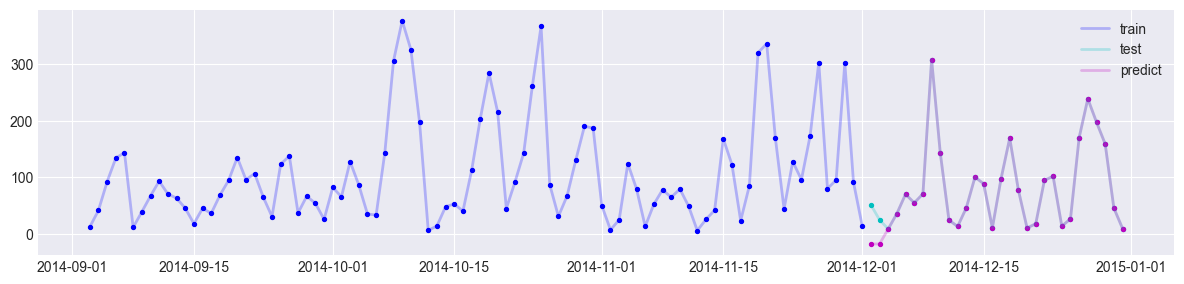

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [16]:
model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

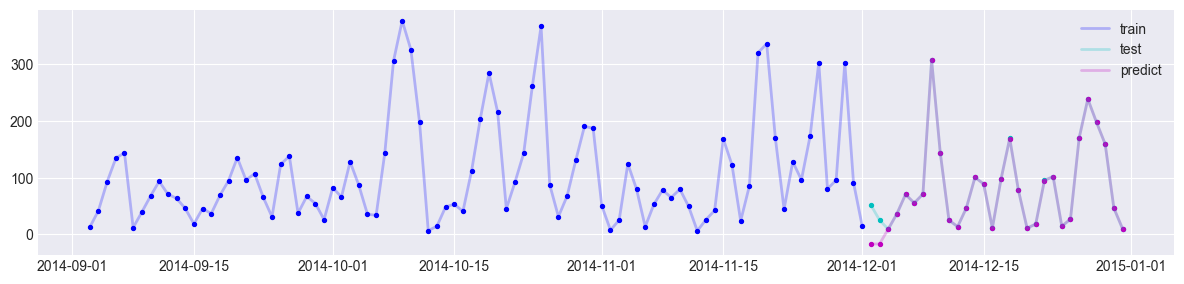

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [ ]:
model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

param_grid = {
    #'bootstrap': [True,False],
    "max_depth": [7, 8, 9],
    "min_samples_leaf": [2, 3],
    "min_samples_split": [7, 8],
    "n_estimators": [300, 500, 600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)
predictionsDF[model_name] = yhat

# resultsDF.head()

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.812 total time=   1.1s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.867 total time=   1.9s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=300;, score=0.916 total time=   3.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.814 total time=   1.7s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.867 total time=   3.4s
[CV 3/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.917 total time=   5.0s
[CV 1/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.814 total time=   2.2s
[CV 2/3] END max_depth=7, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.867 total time=   4.5s
[C

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

In [ ]:
model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [ ]:
model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    early_stopping_rounds=100,
    verbose=True,
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [ ]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=True
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y.pollution.to_numpy(), yhat)

predictionsDF[model_name] = yhat

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
print(grid_search_results["params"])

In [ ]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

In [ ]:
resultsDF.T

In [ ]:
plot_metrics(resultsDF)